# Data Exploration

## Imports

In [1]:
import string

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from collections import Counter
import re
from collections import defaultdict


# Load the data

In [2]:
with open('data/data_df.pkl', 'rb') as f:
    data = pkl.load(f)

## Exploration

### Ingredient histogram

In [3]:
all_ing = []
append_ing = lambda x: all_ing.append(x)
flatten = lambda x: [z for y in x for z in y]

data['ingredients_2'].apply(append_ing)
all_ing = flatten(all_ing)
sort_dict = lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
hist = sort_dict(dict(Counter(all_ing)))

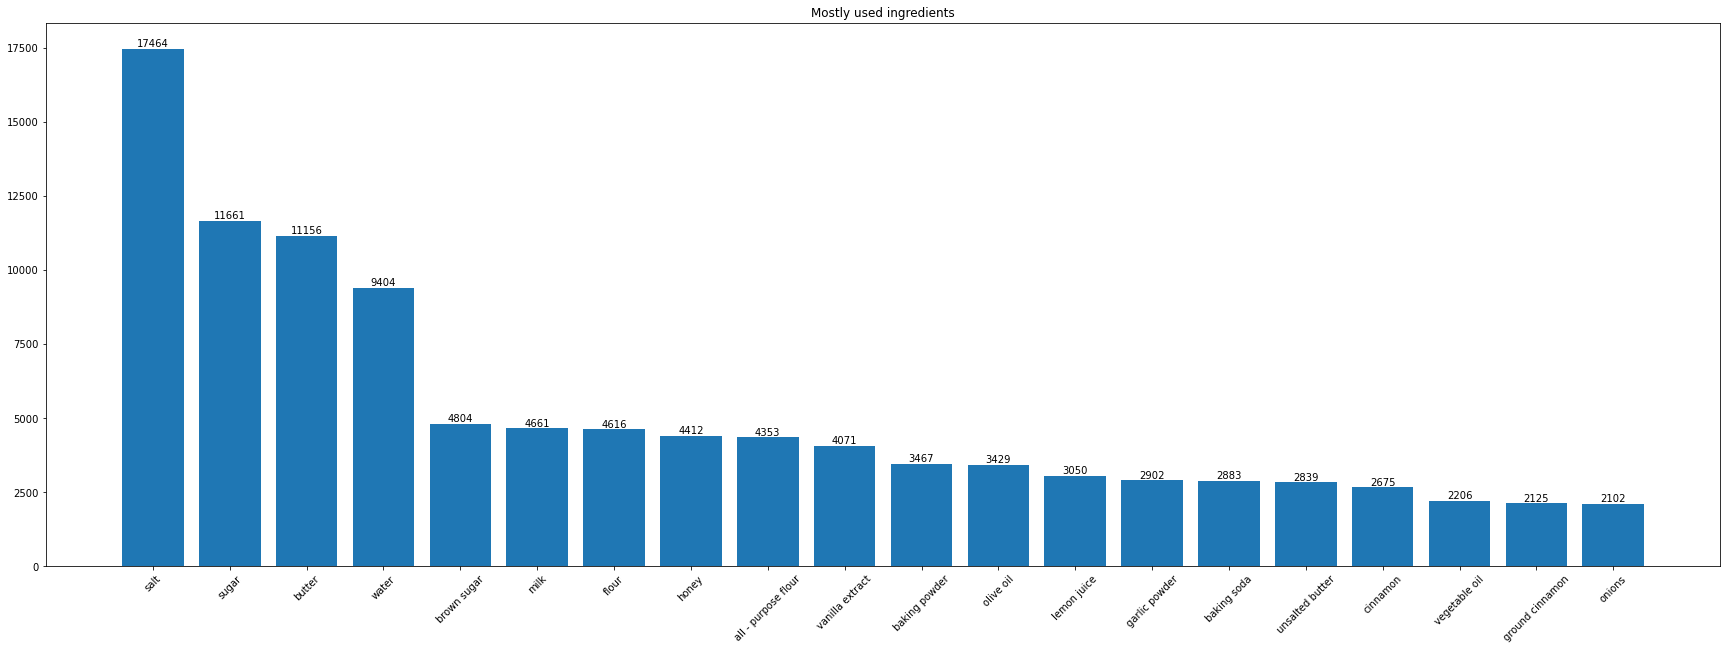

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
bars = ax.bar(*list(zip(*list(hist.items())[:20])))
ax.bar_label(bars)
plt.xticks(rotation=45)
plt.title('Mostly used ingredients')
plt.show()

In [5]:
ingredients_count = pd.DataFrame.from_dict(hist, orient='index', columns=['count'])
ingredients_count['%'] = ingredients_count['count'].cumsum() / ingredients_count['count'].sum()
ingredients_count = ingredients_count.reset_index()

In [6]:
(ingredients_count['%'] > 0.95).reset_index().groupby('%').first()

,index
%,
False,0
True,1269


In [159]:
first_ingredients = ingredients_count[:1300]['index'].to_list()
pkl.dump(first_ingredients, open('data/ingredients/first_ingredients', 'wb'))

### Nutritions

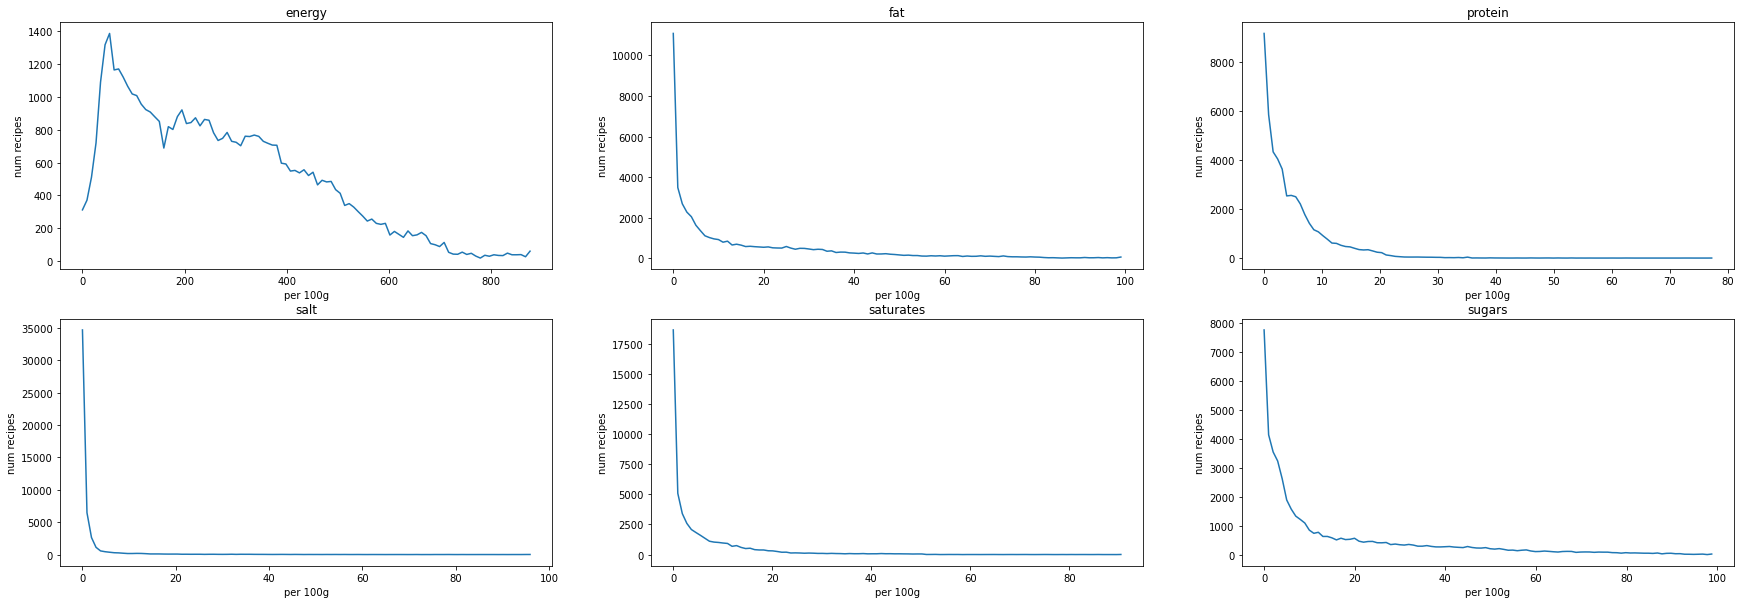

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(30, 10))
nuts = ['energy', 'fat', 'protein', 'salt', 'saturates', 'sugars']
for i, nut in enumerate(nuts):
    ax = axes[i // 3, i % 3]
    hist, bins = np.histogram(data[nut], bins=100)
    ax.plot(bins[:-1], hist)
    ax.set_title(nut)
    ax.set_ylabel("num recipes")
    ax.set_xlabel("per 100g")
plt.show()

### Verb analysis

In [55]:
instructions_1 = data['instructions_1'].explode().reset_index()
instructions_1 = instructions_1.rename(columns={'instructions_1':'instructions'})
instructions_1['instructions'] = instructions_1['instructions'].apply(lambda s: re.sub(r'[^\w\s]', '', s.lower()))
instructions_1['inner_index'] = instructions_1.groupby('index').cumcount()
instructions_1 = instructions_1.set_index(['index', 'inner_index'])
instructions_1

instructions
index      inner_index                                                   
000095fc1d 0                      layer all ingredients in a serving dish
00051d5b9d 0                  cream sugar and butter together till smooth
           1            add in egg beaters orange rind orange juice an...
           2              mix together low sodium baking powder and flour
           3                           add in to creamed mix and mix well
...                                                                   ...
fffdbfd298 6                using hands break into small pieces and serve
           7                  store for up to 3 days in covered container
ffffcd4444 0            julienne the daikon and squeeze out the excess...
           1                               combine all of the ingredients
           2                                              serve on a dish

[376886 rows x 1 columns]

In [56]:
# `verbs` will only include the verbs appear in the instructions, in a lower form
with open('data/verbs.txt') as f:
    verbs = f.read().split('\n')
verbs = [v.lower() for v in verbs]
word_set = set(instructions_1['instructions'].apply(lambda r: r.split(' ')).explode())
verbs = list(word_set.intersection(set(verbs)))

In [57]:
def create_verb_dict(row):
    row_words_set = set(row.split(' '))
    d = {w:row.count(w) for w in row_words_set.intersection(verbs)}
    return d

In [58]:
instructions_1['verb_dict'] = instructions_1['instructions'].apply(create_verb_dict)
instructions_1

instructions  \
index      inner_index                                                      
000095fc1d 0                      layer all ingredients in a serving dish   
00051d5b9d 0                  cream sugar and butter together till smooth   
           1            add in egg beaters orange rind orange juice an...   
           2              mix together low sodium baking powder and flour   
           3                           add in to creamed mix and mix well   
...                                                                   ...   
fffdbfd298 6                using hands break into small pieces and serve   
           7                  store for up to 3 days in covered container   
ffffcd4444 0            julienne the daikon and squeeze out the excess...   
           1                               combine all of the ingredients   
           2                                              serve on a dish   

                                       verb_dict  
index      inner_index                            
000095fc1d 0                        {'layer': 1}  
00051d5b9d 0                                  {}  
           1                {'mix': 1, 'add': 1}  
           2                          {'mix': 1}  
           3                {'mix': 2, 'add': 1}  
...                                          ...  
fffdbfd298 6            {'serve': 1, 'break': 1}  
           7                        {'store': 1}  
ffffcd4444 0                                  {}  
           1                      {'combine': 1}  
           2                        {'serve': 1}  

[376886 rows x 2 columns]

#### Over all recipes

In [10]:
def dsum(*dicts, level='word'):
    # level = 'word' / 'row' / 'recipe'
    ret = defaultdict(int)
    for d in dicts:
        for k, v in d.items():
            if level == 'recipe':
                ret[k] = 1
            else:
                ret[k] += v if level=='word' else 1
    return dict(ret)

In [11]:
over_all = dsum(*instructions_1['verb_dict'].to_list(), level='word')
over_all = pd.DataFrame.from_dict(over_all, orient='index', columns=['over_all']).sort_values('over_all', ascending=False)
over_all

,over_all
add,39902
heat,29597
mix,28182
stir,26347
place,21853
...,...
excuse,1
ought,1
guard,1
attract,1


In [12]:
over_rows = dsum(*instructions_1['verb_dict'].to_list(), level='row')
over_rows = pd.DataFrame.from_dict(over_rows, orient='index', columns=['over_rows']).sort_values('over_rows', ascending=False)
over_rows

,over_rows
add,38364
heat,26512
stir,25493
mix,24875
place,21434
...,...
guard,1
born,1
attract,1
survive,1


In [13]:
each_recipe = instructions_1['verb_dict'].groupby('index').agg(lambda s: dsum(*s.to_list(), level='recipe'))
over_recipes = dsum(*each_recipe.to_list(), level='word')
over_recipes = pd.DataFrame.from_dict(over_recipes, orient='index', columns=['over_recipes']).sort_values('over_recipes', ascending=False)
over_recipes

,over_recipes
add,23786
mix,18535
stir,17511
heat,16407
combine,15515
...,...
cancel,1
generate,1
guard,1
attract,1


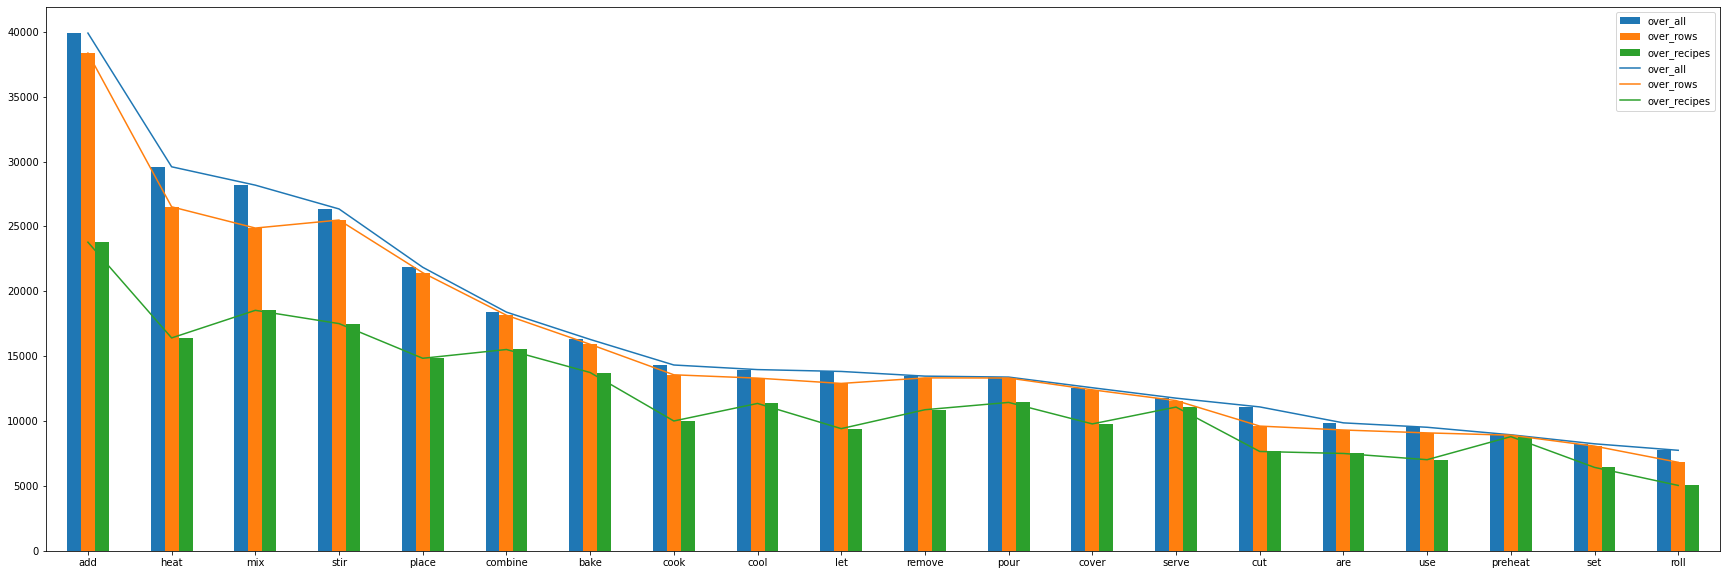

In [14]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
counts = pd.concat([over_all, over_rows, over_recipes], axis=1)
counts_f = counts[[
    'over_all',
    'over_rows',
    'over_recipes'
]]
counts_f.iloc[:20].plot.bar(ax=ax)
counts_f.iloc[:20].plot(ax=ax)
plt.show()

In [16]:
counts.sort_index()

,over_all,over_rows,over_recipes
accept,5,5,4
access,6,6,6
achieve,95,95,90
acquire,3,3,3
act,16,16,16
...,...,...,...
wonder,12,12,12
worry,198,198,191
would,640,628,588
wrap,4481,3805,2939


In [50]:
instructions_1['words'] = instructions_1['verb_dict'].apply(lambda d: list(d.keys()))
words_count = instructions_1[['instructions', 'words']].explode(column='words').reset_index().groupby('words').agg({'index':[list, len], 'inner_index':list, 'instructions':list})
words_count['appearances'] = words_count.apply(lambda s: list(zip(s['index','list'], s['inner_index', 'list'], s['instructions', 'list'])), axis=1)
words_count.columns = words_count.columns.to_flat_index()
words_count = words_count[[('index', 'len'), ('appearances', '')]]
words_count = words_count.rename(columns={('index', 'len'):'len', ('appearances', ''): 'appearances'})
words_count

,len,appearances
words,,
accept,5,"[(25d71bd44d, 13, note i am putting the single..."
access,6,"[(0d732602ff, 5, after you dip each individual..."
achieve,95,"[(03b2f000cd, 1, add water drop by drop to ach..."
acquire,3,"[(1b8e8e2e10, 5, if you dont allow the spices ..."
act,16,"[(26e630c774, 0, in a mason jar combine 12 cup..."
...,...,...
wonder,12,"[(0178269fc8, 1, pour in festive glass top wi..."
worry,198,"[(02732a58fc, 10, note dont worry about using ..."
would,628,"[(01555490b9, 16, grasp or perhaps you would p..."


In [158]:
pkl.dump(instructions_1, open('data/instructions/instructions_1.pkl', 'wb'))